In [3]:
import numpy as np, pandas as pd, scipy.io as sio, glob, os, seaborn as sns, matplotlib.pyplot as plt
from neo.io import BlackrockIO
from neo.rawio import BlackrockRawIO

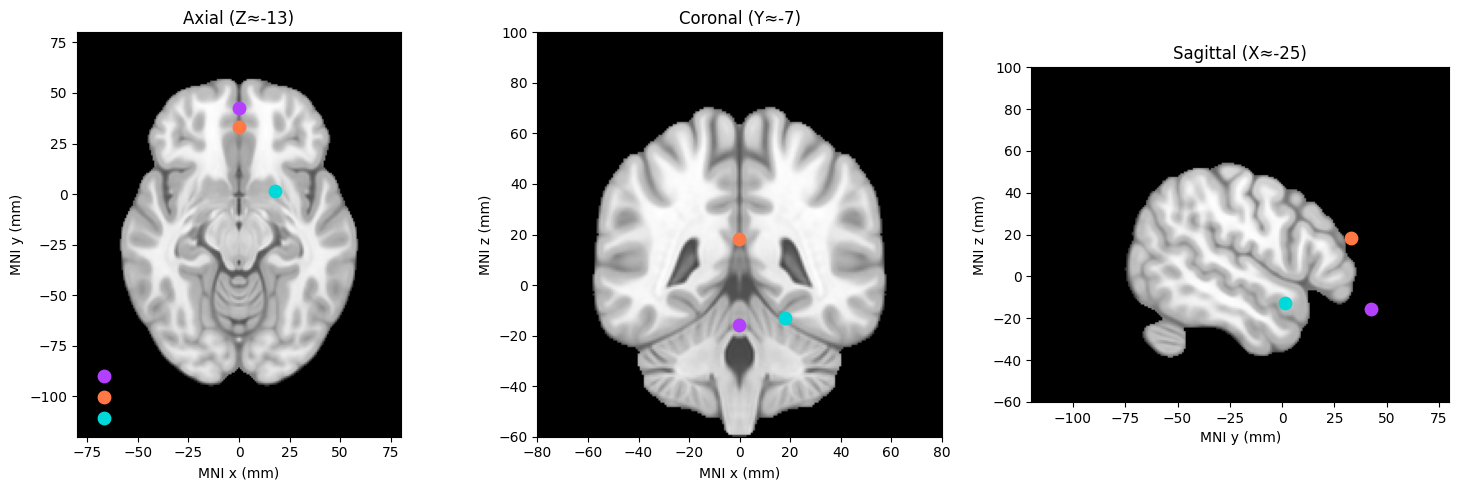

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets

# ----------------------------
# 1. Load MNI template
# ----------------------------
mni = datasets.load_mni152_template()
mni_data = mni.get_fdata()

# Choose slice indices around your coordinates (in voxel space)
x_idx, y_idx, z_idx = 45, 90, 60  # adjust later if you want different depth

# Extract 2D slices
x_slice = np.rot90(mni_data[x_idx, :, :])   # sagittal (y–z)
y_slice = np.rot90(mni_data[:, y_idx, :])   # coronal  (x–z)
z_slice = np.rot90(mni_data[:, :, z_idx])   # axial    (x–y)

# Set MNI display ranges (in mm)
extent_x = [-120, 80, -60, 100]   # sagittal (y,z)
extent_y = [-80, 80, -60, 100]    # coronal  (x,z)
extent_z = [-80, 80, -120, 80]    # axial    (x,y)

# ----------------------------
# 2. Figure setup
# ----------------------------
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# --- Neon colors ---
c1 = [0.7, 0.25, 1]   # purple
c2 = [1, 0.47, 0.27]  # orange-red
c3 = [0, 0.85, 0.85]  # cyan-green
size = 80

# Background anatomy
axs[0].imshow(z_slice, cmap='gray', extent=extent_z)
axs[0].set(title='Axial (Z≈-13)', xlabel='MNI x (mm)', ylabel='MNI y (mm)')

axs[1].imshow(y_slice, cmap='gray', extent=extent_y)
axs[1].set(title='Coronal (Y≈-7)', xlabel='MNI x (mm)', ylabel='MNI z (mm)')

axs[2].imshow(x_slice, cmap='gray', extent=extent_x)
axs[2].set(title='Sagittal (X≈-25)', xlabel='MNI y (mm)', ylabel='MNI z (mm)')

# ---------------------------- -0.111605	42.570655	-15.682235
# 3. Add YOUR electrodes
# ----------------------------
coords = np.array([
    [-0.111605,  42.570655, -15.682235],  # lOFC
    [-0.111605,  32.977269,  18.278047],  # lACC
    [17.885046,   1.399040, -12.885506],  # rHIP
])

coord_regions = ['lOFC', 'lACC', 'rHIP']
colors = [c1, c2, c3]

for (x, y, z), lab, col in zip(coords, coord_regions, colors):
    axs[0].scatter(x, y, color=col, s=size, label=lab)  # axial (x,y)
    axs[1].scatter(x, z, color=col, s=size)             # coronal (x,z)
    axs[2].scatter(y, z, color=col, s=size)             # sagittal (y,z)

axs[0].legend(frameon=False, loc='lower left')

plt.tight_layout()
plt.show()


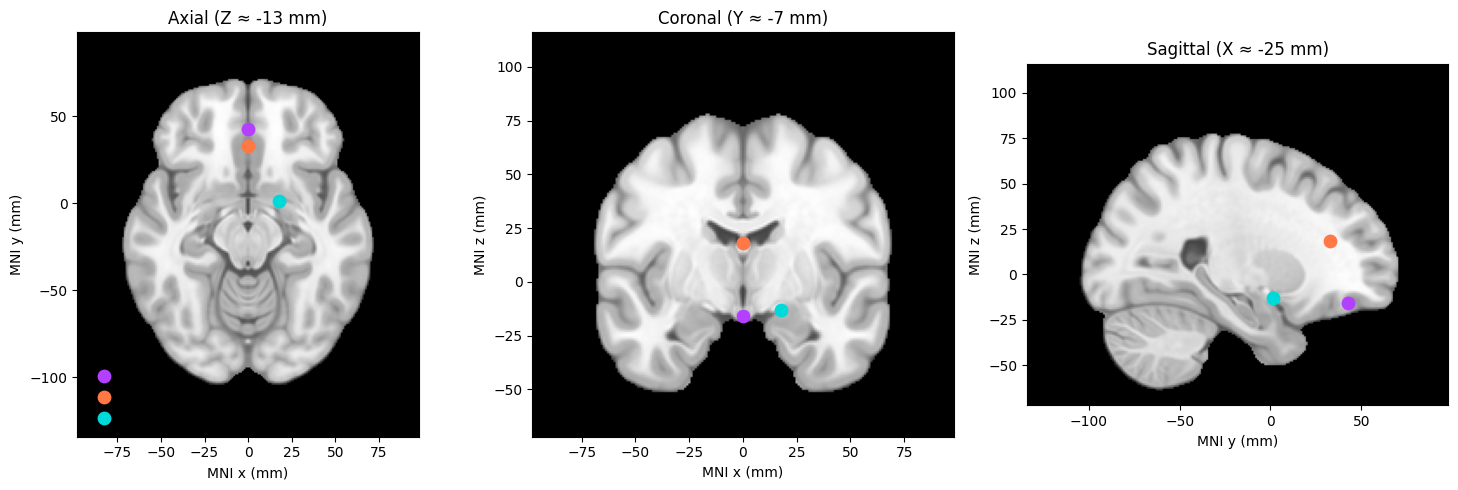

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets

# ----------------------------
# 0) Your electrode coords (MNI mm)
# ----------------------------
coords = np.array([
    [-0.111605,  42.570655, -15.682235],  # lOFC
    [-0.111605,  32.977269,  18.278047],  # lACC
    [17.885046,   1.399040, -12.885506],  # rHIP
])
coord_regions = ['lOFC', 'lACC', 'rHIP']

# ----------------------------
# 1) Load MNI template
# ----------------------------
mni = datasets.load_mni152_template()  # 1mm template
mni_data = mni.get_fdata()
affine = mni.affine
Ainv = np.linalg.inv(affine)

# Helpers to convert between mm and voxel indices
def mm_to_idx(x, y, z):
    i, j, k, _ = Ainv.dot([x, y, z, 1.0])
    return int(round(i)), int(round(j)), int(round(k))

def idx_to_mm(i, j, k):
    X, Y, Z, _ = affine.dot([i, j, k, 1.0])
    return float(X), float(Y), float(Z)

# Compute axis mm ranges from affine + image shape (no hardcoding)
nx, ny, nz = mni_data.shape

def axis_mm_range(axis):
    # axis: 0=x, 1=y, 2=z
    if axis == 0:
        x0, _, _, _ = affine.dot([0, 0, 0, 1.0])
        x1, _, _, _ = affine.dot([nx - 1, 0, 0, 1.0])
        return (min(x0, x1), max(x0, x1))
    if axis == 1:
        _, y0, _, _ = affine.dot([0, 0, 0, 1.0])
        _, y1, _, _ = affine.dot([0, ny - 1, 0, 1.0])
        return (min(y0, y1), max(y0, y1))
    if axis == 2:
        _, _, z0, _ = affine.dot([0, 0, 0, 1.0])
        _, _, z1, _ = affine.dot([0, 0, nz - 1, 1.0])
        return (min(z0, z1), max(z0, z1))
    raise ValueError("axis must be 0,1,2")

x_min, x_max = axis_mm_range(0)
y_min, y_max = axis_mm_range(1)
z_min, z_max = axis_mm_range(2)

# ----------------------------
# 2) Choose slice planes from your coords (median per axis, in mm)
# ----------------------------
x_mm = float(np.median(coords[:, 0]))
y_mm = float(np.median(coords[:, 1]))
z_mm = float(np.median(coords[:, 2]))

x_mm = -25
y_mm = -7
z_mm = -13

# Convert those mm to voxel indices (for slicing)
x_idx, _, _ = mm_to_idx(x_mm, 0, 0)   # sagittal slice index (x axis)
_, y_idx, _ = mm_to_idx(0, y_mm, 0)   # coronal  slice index (y axis)
_, _, z_idx = mm_to_idx(0, 0, z_mm)   # axial    slice index (z axis)

# Also get back the *actual* mm of those indices for accurate titles
Xmm, _, _ = idx_to_mm(x_idx, 0, 0)
_, Ymm, _ = idx_to_mm(0, y_idx, 0)
_, _, Zmm = idx_to_mm(0, 0, z_idx)

# ----------------------------
# 3) Extract slices (no rotation; use origin='lower' with proper extents)
# ----------------------------
# Axial slice at z=z_idx: varies in x (cols) and y (rows)
z_slice = mni_data[:, :, z_idx]
extent_z = [x_min, x_max, y_min, y_max]   # (x range, y range)

# Coronal slice at y=y_idx: varies in x and z
y_slice = mni_data[:, y_idx, :]
extent_y = [x_min, x_max, z_min, z_max]   # (x range, z range)

# Sagittal slice at x=x_idx: varies in y and z
x_slice = mni_data[x_idx, :, :]
extent_x = [y_min, y_max, z_min, z_max]   # (y range, z range)

# ----------------------------
# 4) Plot
# ----------------------------
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Colors
c1 = [0.7, 0.25, 1.0]   # purple
c2 = [1.0, 0.47, 0.27]  # orange-red
c3 = [0.0, 0.85, 0.85]  # cyan-green
colors = [c1, c2, c3]
size = 80

# Axial (x,y @ fixed z)
axs[0].imshow(z_slice.T, cmap='gray', origin='lower', extent=extent_z)  # transpose to put x on horizontal
axs[0].set(title=f'Axial (Z ≈ {Zmm:.0f} mm)', xlabel='MNI x (mm)', ylabel='MNI y (mm)')
for (x, y, z), col, lab in zip(coords, colors, coord_regions):
    axs[0].scatter(x, y, s=size, color=col, label=lab)
axs[0].legend(frameon=False, loc='lower left')

# Coronal (x,z @ fixed y)
axs[1].imshow(y_slice.T, cmap='gray', origin='lower', extent=extent_y)
axs[1].set(title=f'Coronal (Y ≈ {Ymm:.0f} mm)', xlabel='MNI x (mm)', ylabel='MNI z (mm)')
for (x, y, z), col in zip(coords, colors):
    axs[1].scatter(x, z, s=size, color=col)

# Sagittal (y,z @ fixed x)
axs[2].imshow(x_slice.T, cmap='gray', origin='lower', extent=extent_x)
axs[2].set(title=f'Sagittal (X ≈ {Xmm:.0f} mm)', xlabel='MNI y (mm)', ylabel='MNI z (mm)')
for (x, y, z), col in zip(coords, colors):
    axs[2].scatter(y, z, s=size, color=col)

plt.tight_layout()
plt.show()

# save svg
plt.rcParams['svg.fonttype'] = 'none'  # keeps text editable
fig.savefig(f'../../results/figs/sfn/fig2b.svg', format='svg', dpi=300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


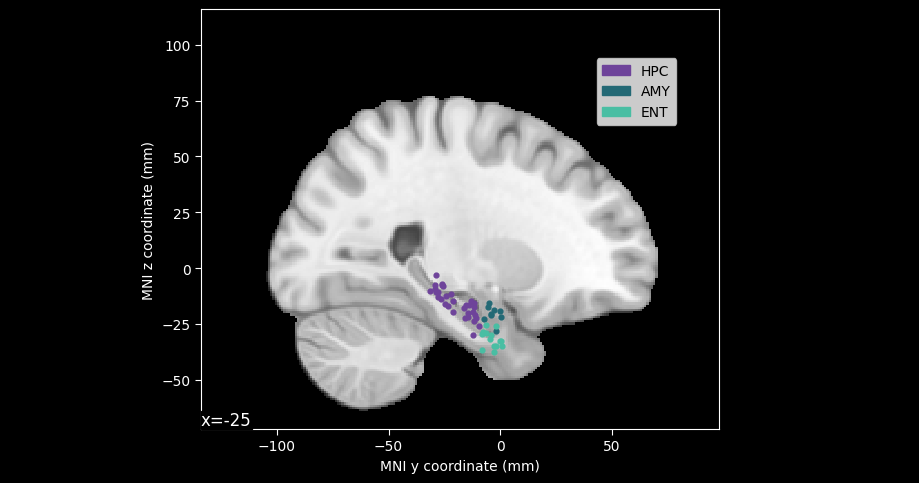

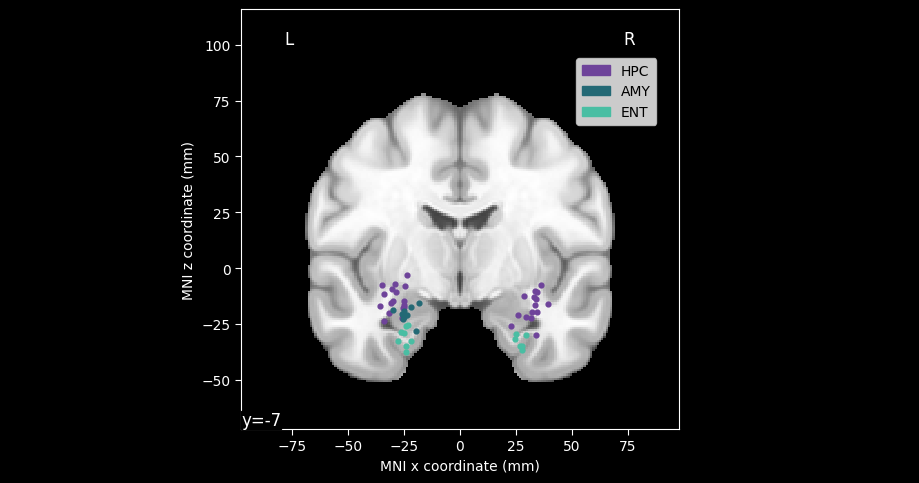

In [87]:
# Precise, extent-aligned axes on nilearn panels (x=-25.2 sagittal, y=-7 coronal)
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from io import StringIO
from nilearn import plotting, datasets
COLORS = {"HPC": "#6E439A", "AMY": "#236975", "ENT": "#49BEA3"}
raw = """electrode	x	y	z
mAHL1	-25.19908493	-12.87539213	-14.7916941
mAL1	-21.93290156	-5.362511565	-17.53302816
mECL1	-24.29368577	-1.664053585	-25.75740882
mLR1	22.08810151	-6.086531418	-17.21103742
mPHL1	-23.81022795	-28.76732478	-3.057946667
mPHR1	33.72471741	-31.49064114	-10.37379102
mAHL1	-34.21598164	-11.60288521	-23.53835589
mAHR1	34.16697089	-12.25469678	-30.13402327
mAL1	-30.14674437	-2.56517475	-18.81904885
Mar1	23.86679867	-1.799957005	-21.12985411
mECL1	-27.85753686	-0.2571363938	-32.40431952
mECR1	26.923157	-2.629251553	-35.00426775
mPHL1	-35.95529957	-23.28799975	-16.88058447
mPHR1	32.44630224	-20.97243352	-19.63583692
mAHL1	-25.76645332	-10.88981098	-22.3589171
mAHR1	25.80573014	-11.08242925	-21.01587904
mAL1	-24.88162703	0.4814770751	-21.80424988
mECL1	-21.87777891	0.1637902461	-32.71446744
mPHL1	-28.49536006	-28.85114923	-10.66439645
mAHL1	-31.75126283	-14.26076978	-19.84493187
mAHR1	34.38637748	-12.18727504	-19.67408448
mAL1	-25.8194063	-3.931409241	-20.31808829
Mar1	21.67164834	-1.174463956	-18.30059332
mECL1	-24.33151586	-1.70382925	-34.73963378
mECR1	27.60161843	0.8201322813	-34.81061346
mPHL1	-30.44646671	-29.0342571	-9.411797501
mPHR1	33.88262437	-26.33461927	-13.79604013
mAHL1	-30.1874843	-20.93108758	-14.66286856
mAL1	-25.43341369	-7.467188989	-22.6484715
mDRR1	44.43221584	-33.47497005	-20.5819878
mPHR1	39.29486242	-24.72134585	-15.86289648
mAHL1	-24.98574827	-11.90703545	-17.44441945
mAHR1	31.80235111	-15.89391971	-22.44142531
mAL1	-25.1591311	-0.0588337345	-19.26910353
Mar1	22.00727145	-3.91161024	-24.97796955
mECL1	-25.27052165	-6.410654377	-28.90737936
mECR1	24.44259641	-4.633755137	-31.50653799
mPHL1	-34.23811866	-22.08354221	-11.36266724
mPHR1	33.2876524	-27.99013189	-12.71974771
mAHL1	-25.27834647	-15.52269647	-16.4586734
mAHR1	29.43215295	-14.24903456	-21.97491342
mAL1	-18.57221236	-5.047449011	-15.46710696
Mar1	22.45759568	-5.795665825	-17.176828
mECL1	-23.17364496	-6.294871132	-25.62450995
mECR1	29.73403959	-3.953001156	-30.02694053
mPHL1	-29.02645873	-26.00743131	-7.178173663
mPHR1	34.52888323	-27.98725347	-10.55349481
mAHL1	-30.85439073	-11.94073715	-15.69944995
mAHR1	33.4505689	-13.87934655	-16.35714876
mAL1	-23.67469532	-3.999533029	-20.97565459
Mar1	22.85121905	-6.226332015	-17.5482966
mECL1	-26.1918036	-7.611772368	-28.75179057
mECR1	25.21400777	-8.053176647	-29.27431369
mPHL1	-35.00473446	-29.20849371	-7.320541711
mPHR1	36.25189867	-25.86774922	-7.34431974
mAHL1	-25.44982938	-16.04603435	-17.73327567
mAHR1	22.86978509	-9.390807126	-25.78270374
mAL1	-19.53660884	-2.06485389	-28.12563375
Mar1	22.86300116	-0.8751033693	-22.44937493
mECL1	-24.05826505	-2.596190627	-37.71151825
mECR1	27.67602199	-7.932493347	-36.56564274
mPHL1	-24.40054513	-25.389323	-8.148932153
mPHR1	28.54786261	-24.45278804	-12.6167252
"""
df = pd.read_csv(StringIO(raw), sep=r"\s+", engine="python")
df.columns = [c.strip().lower() for c in df.columns]
df = df[~df["electrode"].astype(str).str.fullmatch(r"\s*m\s*ar\s*1\s*", case=False)].copy()
def to_family(lbl: str):
    s = str(lbl).upper()
    if re.search(r"(AHL|AHR|PHL|PHR)", s): return "HPC"
    if re.search(r"(AL|AR)", s):           return "AMY"
    if re.search(r"(ECL|ECR)", s):         return "ENT"
    return None
df["family"] = df["electrode"].map(to_family)
df = df[df["family"].notna()].copy()
mni = datasets.load_mni152_template()
MARKER_SIZE = 12
# --- helpers: fetch the real panel axis + align to image extent ---
def panel_mpl_ax(display):
    axes = getattr(display, "axes", None)
    if isinstance(axes, dict):
        v = next(iter(axes.values()))
        base = v[0] if isinstance(v, (list, tuple)) else v
    elif isinstance(axes, (list, tuple)) and axes:
        base = axes[0]
    else:
        base = getattr(display, "ax", None) or getattr(display, "_axes", [None])[0]
    return getattr(base, "ax", base)  # BaseAxes.ax → Matplotlib Axes
def align_to_true_extent(ax, xlabel, ylabel, color="w"):
    """Turn the hidden panel axis ON and sync limits to the actual background image extent."""
    # background is drawn as an AxesImage; pick the last image (safest after markers)
    if not ax.images:
        return
    bg = ax.images[0] if len(ax.images) == 1 else ax.images[-1]
    xmin, xmax, ymin, ymax = bg.get_extent()
    ax.set_axis_on()            # <- crucial: nilearn calls axis("off")
    ax.set_facecolor("none")
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    for s in ax.spines.values():
        s.set_color(color)
    ax.tick_params(colors=color, which="both", direction="out", length=4)
    ax.xaxis.label.set_color(color)
    ax.yaxis.label.set_color(color)
# ===================== Sagittal (x = -25.2): axes (y, z)
x_slice = -25.2
pts_x = df[["x","y","z"]].to_numpy().copy()
if pts_x.size: pts_x[:,0] = x_slice
fig1 = plt.figure(figsize=(9, 4.2))
fig1.patch.set_facecolor("black")
disp_x = plotting.plot_anat(mni, display_mode="x", cut_coords=[x_slice],
                            draw_cross=False, figure=fig1, black_bg=True, dim=0, colorbar=False)
for fam in ("HPC","AMY","ENT"):
    idx = np.where(df["family"].to_numpy()==fam)[0]
    if idx.size:
        disp_x.add_markers(pts_x[idx], marker_color=COLORS[fam], marker_size=MARKER_SIZE)
ax_x = panel_mpl_ax(disp_x)
handles = [Patch(color=COLORS[f], label=f) for f in ("HPC","AMY","ENT") if (df["family"]==f).any()]
if handles:
    ax_x.legend(handles=handles, loc="upper left", bbox_to_anchor=(0.75, 0.90),
                frameon=True)
# Align to the true image extent: (horiz=MNI y, vert=MNI z)
align_to_true_extent(ax_x, xlabel="MNI y coordinate (mm)", ylabel="MNI z coordinate (mm)")
# fig1.text(0.085, 0.11, f"x={x_slice:.0f}", color="w", fontsize=10)
fig1.savefig("mtl_sagittal_x_minus25_TRUEaxes.eps")
# ===================== Coronal (y = -7): axes (x, z)
y_slice = -7.0
pts_y = df[["x","y","z"]].to_numpy().copy()
if pts_y.size: pts_y[:,1] = y_slice
fig2 = plt.figure(figsize=(9, 4.2))
fig2.patch.set_facecolor("black")
disp_y = plotting.plot_anat(mni, display_mode="y", cut_coords=[y_slice],
                            draw_cross=False, figure=fig2, black_bg=True, dim=0, colorbar=False)
for fam in ("HPC","AMY","ENT"):
    idx = np.where(df["family"].to_numpy()==fam)[0]
    if idx.size:
        disp_y.add_markers(pts_y[idx], marker_color=COLORS[fam], marker_size=MARKER_SIZE)
ax_y = panel_mpl_ax(disp_y)
if handles:
    ax_y.legend(handles=handles, loc="upper left", bbox_to_anchor=(0.75, 0.90),
                frameon=True)
# Align to the true image extent: (horiz=MNI x, vert=MNI z)
align_to_true_extent(ax_y, xlabel="MNI x coordinate (mm)", ylabel="MNI z coordinate (mm)")
# fig2.text(0.085, 0.11, f"y={y_slice:.0f}", color="w", fontsize=10)
fig2.savefig("mtl_coronal_y_minus7_TRUEaxes.eps")
plotting.show()

In [ ]:
# df_subjs = pd.DataFrame()

# # init new cols
# for col in ['dir_flip', 'sess_flip',
#             'chosen_pos_aligned', 'div_pos_aligned', 'stim_pos_aligned',
#             'true_class', 'pred_class', 'err_type',
#             'invalid', 'missed', 'purely_incorrect',
#             'signed_err', 'unsigned_err',
#             'dist_moved', 'normed_RT',
#             'difficulty', 'stim_aligned_to_div']:
#     df_subjs[col] = np.nan

# for raw_subj in raw_subjs:

#     df_subj = pd.read_csv(glob.glob(f'../../results/psychopy/*{raw_subj}*')[0])[:240]
#     df_subj['subj'] = df_subj['subj'].replace(subj_map)

#     # trial sort
#     df_subj = df_subj.sort_values(by='trial_key').reset_index(drop=True)
#     assert df_subj['trial_key'].is_monotonic_increasing, 'trial_key is not sorted correctly'

#     # convert str to list, and store chosen position
#     for col in ['positions']:
#         if type(df_subj[col][0]) == str:
#             df_subj.loc[:, col] = df_subj[col].apply(ast.literal_eval)
            
#     df_subj['chosen_pos'] = df_subj['positions'].apply(lambda x: x[-1])
    
# ## must sequentially align for flips & sessions because of the double flip situations

# # 1. aligning for direction flips
#     df_subj['dir_flip'] = (df_subj['shape_order'] == 'flat_curv').astype(int)
#     assert df_subj['dir_flip'].sum() == len(df_subj)/2
   
#    # align positions to curv=left, flat=right
#     for col_prefix in ['chosen_pos', 'div_pos']: # dont need to unflip stim_pos because it never gets flipped; only target_pos does
#         df_subj[col_prefix + '_aligned'] = np.where( df_subj['dir_flip'],
#                                                      -df_subj[col_prefix], df_subj[col_prefix] )

# # 2. aligning for session type (stim-val association)
#     if df_subj['sess_type'][0] in ['A', 'C']: # adam, tori       
#         df_subj['condition'] = df_subj['condition'].map({'baseline':'baseline', 'curv_comp':'pen_comp', 'flat_comp':'rew_comp'})
#         df_subj['sess_flip'] = 0
#         df_subj['stim_pos_aligned'] = df_subj['stim_pos']

#     elif df_subj['sess_type'][0] in ['B', 'D']: # amisha, erfan     
#         df_subj['condition'] = df_subj['condition'].map({'baseline':'baseline', 'curv_comp':'rew_comp', 'flat_comp':'pen_comp'})
#         df_subj['sess_flip'] = 1
#         df_subj['stim_pos_aligned'] = -df_subj['stim_pos']

#         # align positions to penalty=left, reward=right
#         for col in ['chosen_pos_aligned', 'div_pos_aligned']:
#             df_subj[col] = -df_subj[col]

#     df_subjs = pd.concat([df_subjs, df_subj], ignore_index=True)

# # category stuff
# df_subjs['true_class'] = np.where( df_subjs['valence'] == 'rew', 1, 0 ) 
# df_subjs['pred_class'] = (df_subjs['div_pos_aligned'] < df_subjs['chosen_pos_aligned']).astype(int)
# df_subjs['err_type'] = df_subjs['pred_class'] - df_subjs['true_class']

# # outcome stuff
# df_subjs['outcome'] = df_subjs['outcome'].replace({2: 3, -2: -3}) # older versions
# # for PILOTS, convert 0 to -1 or -3 depending on whether true_class is 1 or 0
# df_subjs['outcome'] = np.where( (df_subjs['true_class'] == 1) & (df_subjs['outcome'] == 0), -1,
#                              np.where( (df_subjs['true_class'] == 0) & (df_subjs['outcome'] == 0), -3,
#                                       df_subjs['outcome'] ) )

# # invalid and missed trials
# df_subjs['invalid'] = df_subjs['trials.slider_resp.rt'].isna()
# df_subjs['missed'] = df_subjs['trials.submit_resp.keys'].isna()
# df_subjs['purely_incorrect'] = (df_subjs['correct']==0) & ~df_subjs['trials.slider_resp.rt'].isna() & ~df_subjs['trials.submit_resp.keys'].isna()

# # continuous resp
# df_subjs['signed_err'] = df_subjs['chosen_pos_aligned'] - df_subjs['stim_pos_aligned']
# df_subjs['unsigned_err'] = (df_subjs['chosen_pos_aligned'] - df_subjs['stim_pos_aligned']).abs()

# # RT
# df_subjs['dist_moved'] = (df_subjs['chosen_pos'] - df_subjs['marker_init']).abs()
# df_subjs['normed_RT'] = df_subjs['trials.submit_resp.rt']/ (10 * (df_subjs['dist_moved'] + .01) )

# # boundary stuff
# df_subjs['difficulty'] = (df_subjs['stim_pos_aligned'] - df_subjs['div_pos_aligned']).abs() < 0.1
# df_subjs['stim_aligned_to_div'] = (df_subjs['stim_pos_aligned'] - df_subjs['div_pos_aligned']).round(3)

# # rank within a block for each subj/cond
# grp = ['subj', 'condition', 'blockN']
# # build both ranks, assign once, then copy to defragment
# df_subjs = df_subjs.assign(
#     stim_ranks = df_subjs.groupby(grp)['stim_pos_aligned'].transform('rank'),
#     resp_ranks = df_subjs.groupby(grp)['chosen_pos_aligned'].transform('rank'),
# ).copy()
# max_rank = df_subjs['stim_ranks'].max()

# df_subjs = df_subjs.copy()

# # asserts
# df_subjs.to_csv('../../results/psychopy/all_subjs_clean.csv', index=False)

# print(df_subjs['outcome'].value_counts(), '\n')
# print(df_subjs['correct'].value_counts(), '\n')
# print(df_subjs.shape, '\n')
# print(len(df_subjs))
# assert len(df_subjs) == 240 * len(raw_subjs), "Total trials do not match expected number"

# disp_cols = ['sess_type', 'sess_flip', 'shape_order', 'dir_flip', 'target_pos', 'shape', 'valence', 'true_class',
#              'div_pos', 'div_pos_aligned', 'stim_pos', 'stim_pos_aligned', 'chosen_pos', 'chosen_pos_aligned', 'pred_class', 'err_type',
#              'signed_err', 'unsigned_err']

# df_subjs[(df_subjs['sess_type'] == 'B') &
#          (df_subjs['condition'] == 'baseline') &
#          (df_subjs['err_type'] != 0) &
#          (df_subjs['sess_flip'] != df_subjs['dir_flip'])
#         ][disp_cols][:20]


NameError: name 'raw_subjs' is not defined

In [116]:
psychopy_df = pd.read_csv('../../results/psychopy/all_subjs_clean.csv')
psychopy_df = psychopy_df[psychopy_df['subj'].isin(['12', '18'])]
print(len(psychopy_df))

# rename pen_comp to gain_exp and rew_comp to loss_exp
psychopy_df['condition'] = psychopy_df['condition'].replace({'pen_comp':'gain_exp', 'rew_comp':'loss_exp'})

# compute true resp and true bound
psychopy_df['true_resp'] = np.where(psychopy_df['dir_flip'], -psychopy_df['chosen_pos'], psychopy_df['chosen_pos'])
psychopy_df['true_bound'] = np.where(psychopy_df['dir_flip'], -psychopy_df['div_pos'], psychopy_df['div_pos'])

# create map of old to new names
rename_map = {
    'stim_pos': 'true_stim', 'shape': 'shape_class',
    'target_pos': 'stim_disp', 'div_pos': 'bound_disp', 'chosen_pos': 'resp_disp', 'positions': 'positions_disp',
    'trials.submit_resp.rt': 'RT',
    'stim_pos_aligned': 'true_stim_aligned_to_valence', 'div_pos_aligned': 'true_bound_aligned_to_valence', 'chosen_pos_aligned': 'true_resp_aligned_to_valence'
}
psychopy_df = psychopy_df.rename(columns=rename_map)

# retain only necessary columns
col_names = ['subj', 'trial_key', 'condition',
             'shape_class', 'valence', 'true_stim', 'true_bound','true_resp',
             'dir_flip', 'stim_disp', 'bound_disp', 'resp_disp',
             'positions_disp', 
             'correct', 'outcome', 'missed', 'invalid',
             'dist_moved', 'RT', 'normed_RT',
             'sess_flip', 'true_stim_aligned_to_valence', 'true_bound_aligned_to_valence', 'true_resp_aligned_to_valence']
psychopy_df = psychopy_df[col_names]

psychopy_df.to_csv('../../results/psychopy/csv_to_nuttida.csv', index=False)

480


columns i would care about:
'subj', 'trial_key', 'condition',
'shape_class', 'true_stim', 'true_bound','true_resp',
'dir_flip', 'stim_disp', 'bound_disp', 'resp_disp',
'positions_disp', 
'correct', 'outcome', 'missed', 'invalid',
'dist_moved', 'trials.submit_resp.rt', 'normed_RT',
'sess_flip', 'true_stim_aligned_to_valence', 'true_bound_aligned_to_valence', 'true_resp_aligned_to_valence' # last row optional

some column definitions:
shape class = curv of flat RELATIVE to boundary
true_stim/bound/resp: true positions of shape, boundary, response (accounting for direction counterbalancing of response window)
dir_flip: direction of response window. if curv=left & flat=right, then 0; else 1
stim/bound/resp_disp: positions displayed depending on dir_flip
positions_disp: all slider positions displayed as subj moves it
missed: RT times out
invalid: didnt move slider
normed_RT: RT normed by distance moved

optional cols below:
sess_flip: if curv=loss & flat=gain, then 0; else 1
true_stim/bound/resp_aligned_to_valence: flipped depending on sess_flip, so that you can always plot loss on the left side and gain on the right side, regardless of which shape was what context for the subj

In [119]:
subj, cond = '18', 'gain_exp'
tst_df = psychopy_df[(psychopy_df['subj'] == subj) & (psychopy_df['condition'] == cond)][:40] # 1st block
tst_df = tst_df.sort_values(by='trial_key').reset_index(drop=True)
tst_df[15:25]

,subj,trial_key,condition,shape_class,valence,true_stim,true_bound,true_resp,dir_flip,stim_disp,...,outcome,missed,invalid,dist_moved,RT,normed_RT,sess_flip,true_stim_aligned_to_valence,true_bound_aligned_to_valence,true_resp_aligned_to_valence
15,18,95.0,gain_exp,curv,rew,0.10,0.2,0.168,1.0,-0.10,...,3.0,False,False,0.384,1.563859,0.396919,1.0,-0.10,-0.2,-0.168
16,18,96.0,gain_exp,curv,rew,0.14,0.2,0.144,0.0,0.14,...,3.0,False,False,0.040,2.328490,4.656980,1.0,-0.14,-0.2,-0.144
17,18,97.0,gain_exp,curv,rew,0.14,0.2,0.124,1.0,-0.14,...,3.0,False,False,0.120,1.254530,0.965023,1.0,-0.14,-0.2,-0.124
18,18,98.0,gain_exp,curv,rew,0.18,0.2,0.252,0.0,0.18,...,-1.0,False,False,0.000,2.441100,24.410998,1.0,-0.18,-0.2,-0.252
19,18,99.0,gain_exp,curv,rew,0.18,0.2,0.188,1.0,-0.18,...,3.0,False,False,0.424,1.609960,0.370959,1.0,-0.18,-0.2,-0.188
20,18,100.0,gain_exp,flat,pen,0.22,0.2,0.220,0.0,0.22,...,1.0,False,False,0.264,1.535588,0.560433,1.0,-0.22,-0.2,-0.220
21,18,101.0,gain_exp,flat,pen,0.22,0.2,0.256,1.0,-0.22,...,1.0,False,False,0.424,2.493654,0.574575,1.0,-0.22,-0.2,-0.256
22,18,102.0,gain_exp,flat,pen,0.22,0.2,0.292,0.0,0.22,...,1.0,False,False,0.072,1.272600,1.551952,1.0,-0.22,-0.2,-0.292
23,18,103.0,gain_exp,flat,pen,0.22,0.2,0.172,1.0,-0.22,...,-3.0,False,False,0.512,1.711120,0.327801,1.0,-0.22,-0.2,-0.172
24,18,104.0,gain_exp,flat,pen,0.26,0.2,0.224,0.0,0.26,...,1.0,False,False,0.144,1.294727,0.840732,1.0,-0.26,-0.2,-0.224
